In [40]:
import pandas as pd
import os
import json
from collections import defaultdict

# Define paths
trait_files = {
    "evil": [
        "C:/github/thesis/data/pseudo_names/all_names_evil.csv",
        "C:/github/thesis/data/company_names/company_names_evil.csv"
    ],
    "feminine": [
        "C:/github/thesis/data/pseudo_names/all_names_feminine.csv",
        "C:/github/thesis/data/company_names/company_names_feminine.csv"
    ],
    "smart": [
        "C:/github/thesis/data/pseudo_names/all_names_smart.csv",
        "C:/github/thesis/data/company_names/company_names_smart.csv"
    ],
    "trustworthy": [
        "C:/github/thesis/data/pseudo_names/all_names_trustworthy.csv",
        "C:/github/thesis/data/company_names/company_names_trustworthy.csv"
    ]
}

# Output directory
output_dir = "C:/github/thesis/data/output_json_by_trait"
os.makedirs(output_dir, exist_ok=True)

# Translate word types
word_type_map = {
    "bedrijfsnamen": "company",
    "namen": "pseudo"
}

# Save progress function
def save_json(data, trait):
    path = os.path.join(output_dir, f"{trait}.json")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Process each trait
for trait, file_list in trait_files.items():
    data = defaultdict(lambda: {"type": "", "ratings": []})
    count = 0

    for file_path in file_list:
        df = pd.read_csv(file_path)

        for _, row in df.iterrows():
            word = row["word"]
            raw_type = row["word_type"]
            rating = row["rating_value"]

            clean_type = word_type_map.get(raw_type.strip().lower(), "unknown")

            data[word]["type"] = clean_type
            data[word]["ratings"].append(rating)

            count += 1
            if count % 200000 == 0:
                print(trait, file_path)
                save_json(data, trait)

    # Final save
    save_json(data, trait)

print("✅ All traits processed and saved to JSON.")


evil C:/github/thesis/data/pseudo_names/all_names_evil.csv


KeyboardInterrupt: 

In [ ]:
import json
import os
import pandas as pd

# Paths
json_dir = "C:/github/thesis/data/output_json_by_trait"
output_dir = os.path.join(json_dir, "trait_csvs")
os.makedirs(output_dir, exist_ok=True)

traits = ["feminine", "evil", "trustworthy", "smart"]

for trait in traits:
    json_path = os.path.join(json_dir, f"{trait}.json")
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    rows = []
    for word, info in data.items():
        avg_rating = sum(info["ratings"]) / len(info["ratings"]) if info["ratings"] else None
        word_type = info.get("type", "unknown")  # fallback to 'unknown' if type is missing
        if word_type == "unknown":
            word_type= "name"
            
        rows.append({
            "word": word,
            "type": word_type,
            "average_rating": avg_rating
        })

    df = pd.DataFrame(rows)

    # Save with correct structure
    df.to_csv(os.path.join(output_dir, f"{trait}_avg.csv"), index=False)

print("✅ Fixed: Names with unknown type are correctly labeled and saved.")


✅ Fixed: Names with unknown type are correctly labeled and saved.



📊 Trait: feminine
Count: 600
Mean: -0.0006
Std Dev: 0.8086
Min: -2.4583
Max: 3.0670
Skewness: 0.3557


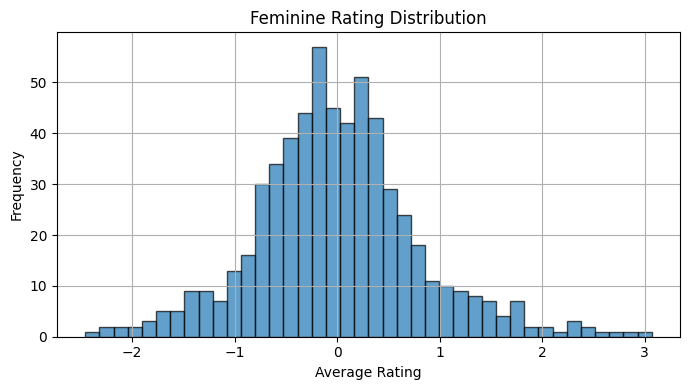


📊 Trait: evil
Count: 600
Mean: -0.0000
Std Dev: 0.3770
Min: -1.1621
Max: 1.6606
Skewness: 0.0072


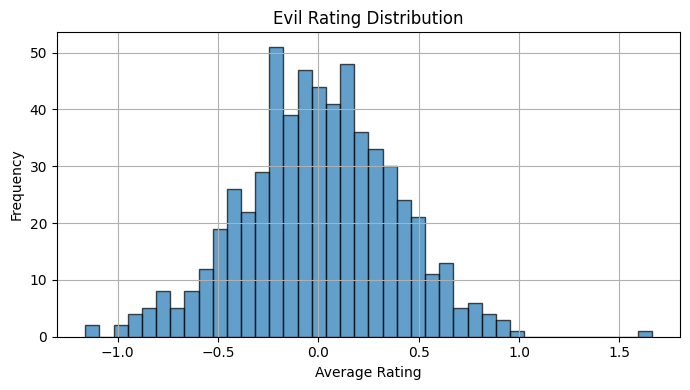


📊 Trait: trustworthy
Count: 600
Mean: 0.0001
Std Dev: 0.3211
Min: -1.1607
Max: 0.9563
Skewness: -0.1287


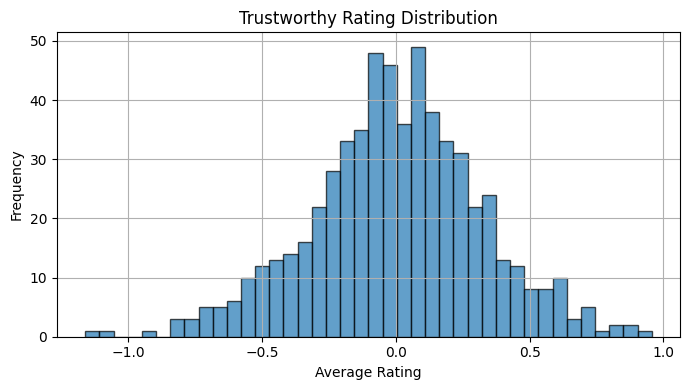


📊 Trait: smart
Count: 600
Mean: -0.0000
Std Dev: 0.3418
Min: -1.0583
Max: 1.1430
Skewness: 0.0077


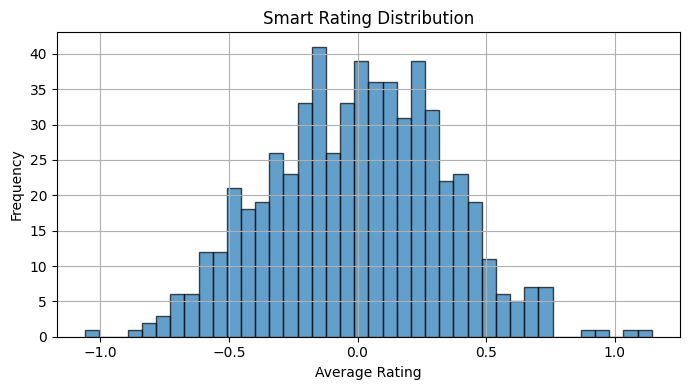

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

# Setup
traits = ["feminine", "evil", "trustworthy", "smart"]
csv_dir = "C:/github/thesis/data/output_json_by_trait/trait_csvs"

# Summary printout
for trait in traits:
    path = os.path.join(csv_dir, f"{trait}_avg.csv")
    df = pd.read_csv(path)
    ratings = df["average_rating"]

    print(f"\n📊 Trait: {trait}")
    print(f"Count: {len(ratings)}")
    print(f"Mean: {ratings.mean():.4f}")
    print(f"Std Dev: {ratings.std():.4f}")
    print(f"Min: {ratings.min():.4f}")
    print(f"Max: {ratings.max():.4f}")
    print(f"Skewness: {skew(ratings):.4f}")

    # Plot
    plt.figure(figsize=(7, 4))
    plt.hist(ratings, bins=40, edgecolor="black", alpha=0.7)
    plt.title(f"{trait.capitalize()} Rating Distribution")
    plt.xlabel("Average Rating")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import pandas as pd

# Traits and base paths
traits = ["feminine", "evil", "trustworthy", "smart"]
csv_dir = "C:/github/thesis/data/output_json_by_trait/trait_csvs"
output_base = "C:/github/thesis/data/splits"

# Load and organize trait data
trait_data = {}
for trait in traits:
    df = pd.read_csv(os.path.join(csv_dir, f"{trait}_avg.csv"))
    df["trait"] = trait
    trait_data[trait] = df

# Setup splits
splits = {
    "model_400pseudo_0company_test200": 0,
    "model_400pseudo_100company_test100": 100,
}

# Create datasets
for model_name, company_n in splits.items():
    model_dir = os.path.join(output_base, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    for trait in traits:
        df = trait_data[trait]
        pseudo_name_df = df[df["type"].isin(["pseudo", "name"])].copy()
        company_df = df[df["type"] == "company"].sample(frac=1, random_state=42).reset_index(drop=True)

        # Train = pseudo+name + some company names
        train_df = pd.concat([pseudo_name_df, company_df.iloc[:company_n]], ignore_index=True)
        test_df = company_df.iloc[company_n:].copy()

        # Save
        train_df.to_csv(os.path.join(model_dir, f"train_{trait}.csv"), index=False)
        test_df.to_csv(os.path.join(model_dir, f"test_{trait}.csv"), index=False)

print("✅ All splits created with correct structure.")


✅ All splits created with correct structure.


In [ ]:
import os
import pandas as pd

traits = ["feminine", "evil", "trustworthy", "smart"]
csv_dir = "C:/github/thesis/data/output_json_by_trait/trait_csvs"
output_dir = "C:/github/thesis/data/splits/model_200company_only"
os.makedirs(output_dir, exist_ok=True)

for trait in traits:
    df = pd.read_csv(os.path.join(csv_dir, f"{trait}_avg.csv"))
    company_df = df[df["type"] == "company"].sample(frac=1, random_state=42).reset_index(drop=True)

    split_index = int(0.75 * len(company_df))
    train_df = company_df.iloc[:split_index].copy()
    test_df = company_df.iloc[split_index:].copy()

    train_df.to_csv(os.path.join(output_dir, f"train_{trait}.csv"), index=False)
    test_df.to_csv(os.path.join(output_dir, f"test_{trait}.csv"), index=False)

print("✅ Model 4 split complete: 150 train / 50 test — using only company names.")


✅ Model 4 split complete: 150 train / 50 test — using only company names.


In [ ]:
import os
import json
import pandas as pd
from collections import Counter

# Paths
traits = ["feminine", "evil", "trustworthy", "smart"]
csv_dir = "C:/github/thesis/data/output_json_by_trait/trait_csvs"
output_path = "C:/github/thesis/data/feature_jsons/unigram_bigram_features.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Collect all unique words and types
words = {}
for trait in traits:
    df = pd.read_csv(os.path.join(csv_dir, f"{trait}_avg.csv"))
    for _, row in df.iterrows():
        word = row["word"]
        words[word] = row["type"]

# Extract unigrams and bigrams
def extract_features(word):
    padded = f"<{word.lower()}>"
    unigrams = list(word.lower())
    bigrams = [padded[i:i+2] for i in range(len(padded)-1)]
    return Counter(unigrams), Counter(bigrams)

# Build feature dictionary
feature_dict = {}
for word, word_type in words.items():
    unigrams, bigrams = extract_features(word)
    feature_dict[word] = {
        "type": word_type,
        "unigrams": unigrams,
        "bigrams": bigrams
    }

# Save to JSON
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(feature_dict, f, ensure_ascii=False, indent=2)

print("✅ Saved unigram and bigram features to:")
print(output_path)


✅ Saved unigram and bigram features to:
C:/github/thesis/data/feature_jsons/unigram_bigram_features.json


In [86]:
import os
import json
import pandas as pd
from collections import Counter

# 1) Paths & traits
traits    = ["feminine", "evil", "trustworthy", "smart"]
csv_dir   = "C:/github/thesis/data/output_json_by_trait/trait_csvs"
out_dir   = "C:/github/thesis/data/feature_vectors"
os.makedirs(out_dir, exist_ok=True)

# 2) Gather all words & reclaim their counters
word_counters = {}
for trait in traits:
    df = pd.read_csv(f"{csv_dir}/{trait}_avg.csv")
    for _, row in df.iterrows():
        w = row["word"].lower()
        if w not in word_counters:
            padded = f"<{w}>"
            uni = list(w)
            bi  = [padded[i:i+2] for i in range(len(padded)-1)]
            word_counters[w] = {
                "unigrams": Counter(uni),
                "bigrams" : Counter(bi)
            }

# 3) Build global vocab lists
all_unis = sorted({u for wc in word_counters.values() for u in wc["unigrams"]})
all_bis  = sorted({b for wc in word_counters.values() for b in wc["bigrams"]})

# Also build vocab list for <c and c> bigrams only
edge_bis = sorted({b for b in all_bis if b.startswith("<") or b.endswith(">")})

print("number of uni features:", len(all_unis))
print("number of all bigram features:", len(all_bis))
print("number of edge bigram features (<c, c>):", len(edge_bis))

# 4) Vectorize
uni_vectors = {}
bi_vectors  = {}

for w, cnts in word_counters.items():
    uni_vectors[w]  = [cnts["unigrams"].get(u, 0) for u in all_unis]
    bi_vectors[w]   = [cnts["bigrams"].get(b, 0) for b in all_bis]

# 5) Save files
with open(f"{out_dir}/unigram_feature_vectors.json", "w", encoding="utf-8") as f:
    json.dump({"vocab": all_unis, "vectors": uni_vectors}, f, indent=2)

with open(f"{out_dir}/bigram_feature_vectors.json", "w", encoding="utf-8") as f:
    json.dump({"vocab": all_bis, "vectors": bi_vectors}, f, indent=2)

print("✅ Saved unigram, bigram, and edge bigram feature vectors to", out_dir)


number of uni features: 27
number of all bigram features: 479
number of edge bigram features (<c, c>): 50
✅ Saved unigram, bigram, and edge bigram feature vectors to C:/github/thesis/data/feature_vectors


In [68]:
import os
import json
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

# 1) Paths & traits
traits = ["feminine","evil","trustworthy","smart"]
csv_dir = "C:/github/thesis/data/output_json_by_trait/trait_csvs"
out_dir = "C:/github/thesis/data/feature_vectors"
os.makedirs(out_dir, exist_ok=True)

# 2) Collect all unique words
words = set()
for trait in traits:
    df = pd.read_csv(f"{csv_dir}/{trait}_avg.csv")
    words.update(df["word"].str.lower().tolist())
words = sorted(words)

# 3) Load RobBERT tokenizer & model
model_name = "pdelobelle/robbert-v2-dutch-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# 4) Extract embeddings (mean of token embeddings)
robbert_vectors = {}
with torch.no_grad():
    for word in words:
        inputs = tokenizer(word, return_tensors="pt")
        outputs = model(**inputs)
        # take the mean of last_hidden_state across tokens
        embed = outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
        robbert_vectors[word] = embed

# 5) Save to JSON
out_path = os.path.join(out_dir, "robbert_feature_vectors.json")
with open(out_path, "w", encoding="utf-8") as f:
    json.dump({"vocab": words, "vectors": robbert_vectors}, f, ensure_ascii=False)

print("✅ Saved RobBERT embeddings for each word to", out_path)


c:\github\thesis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Saved RobBERT embeddings for each word to C:/github/thesis/data/feature_vectors\robbert_feature_vectors.json


working on models

In [ ]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import ElasticNet
from sklearn.pipeline         import Pipeline
from sklearn.model_selection  import GridSearchCV, StratifiedKFold
from sklearn.metrics          import r2_score, mean_squared_error
import joblib

# ── Paths ──────────────────────────────────────────────────────────────────────
BASE       = r"C:\github\thesis\data"
SPLIT_DIR  = os.path.join(BASE, "splits", "model_200company_only")
MODELS_DIR = os.path.join(BASE, "models", "model_200company_only")
FV_DIR     = os.path.join(BASE, "feature_vectors")
os.makedirs(MODELS_DIR, exist_ok=True)

# ── Hyperparams & CV ───────────────────────────────────────────────────────────
param_grid = {
    "model__alpha":    [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Load feature data ───────────────────────────────────────────────────────────
uni = json.load(open(os.path.join(FV_DIR, "unigram_feature_vectors.json"),  "r"))
bi  = json.load(open(os.path.join(FV_DIR, "bigram_feature_vectors.json"),   "r"))
rob = json.load(open(os.path.join(FV_DIR, "robbert_feature_vectors.json"),  "r"))

uni_vecs = uni["vectors"];     unigrams = uni["vocab"]
bi_vecs  = bi["vectors"];      bigrams  = bi["vocab"]
rob_vecs = rob["vectors"]
rob_dims = [f"dim_{i}" for i in range(len(next(iter(rob_vecs.values()))))]

# ── Define feature‐set builders ────────────────────────────────────────────────
feature_sets = {
    "unigram": {
      "build": lambda W: np.vstack([uni_vecs[w.lower()] for w in W]),
      "names": unigrams
    },
    "bigram": {
      "build": lambda W: np.vstack([bi_vecs[w.lower()]  for w in W]),
      "names": bigrams
    },
    "robbert": {
      "build": lambda W: np.vstack([rob_vecs[w.lower()] for w in W]),
      "names": rob_dims
    },
    "combined": {
      "build": lambda W: np.hstack([
          np.vstack([uni_vecs[w.lower()] for w in W]),
          np.vstack([bi_vecs[w.lower()]  for w in W]),
          np.vstack([rob_vecs[w.lower()] for w in W])
      ]),
      "names": unigrams + bigrams + rob_dims
    }
}

traits = ["feminine", "evil", "trustworthy", "smart"]

# ── Train & save ───────────────────────────────────────────────────────────────
for feat, cfg in feature_sets.items():
    out = os.path.join(MODELS_DIR, f"{feat}_elasticnet")
    os.makedirs(out, exist_ok=True)
    records = []

    for tr in traits:
        # load splits
        trn = pd.read_csv(os.path.join(SPLIT_DIR, f"train_{tr}.csv"))
        tst = pd.read_csv(os.path.join(SPLIT_DIR, f"test_{tr}.csv"))

        # build X/y
        X_tr = cfg["build"](trn["word"])
        X_te = cfg["build"](tst["word"])
        y_tr = trn["average_rating"].values
        y_te = tst["average_rating"].values

        # stratify by pseudo/name/company (0,1,2)
        dom = trn["type"].map({"pseudo":0, "name":1, "company":2}).values

        # pipeline + grid search
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", ElasticNet(max_iter=5000))])
        grid = GridSearchCV(pipe, param_grid,
                            cv=skf.split(X_tr, dom),
                            scoring="r2", n_jobs=-1, error_score=np.nan)
        grid.fit(X_tr, y_tr)

        best   = grid.best_estimator_
        params = grid.best_params_
        cv_r2  = grid.best_score_

        # importances
        coefs = best.named_steps["model"].coef_
        imp   = pd.DataFrame({
          feat:            cfg["names"],
          "coefficient":   coefs
        })
        imp["abs_imp"] = imp["coefficient"].abs()
        imp = imp[imp["coefficient"] != 0]\
              .sort_values("abs_imp", ascending=False)
        imp.to_csv(os.path.join(out, f"{tr}_{feat}_importances.csv"),
                   index=False)

        # eval
        ytr_p = best.predict(X_tr)
        yte_p = best.predict(X_te)
        r2_tr = r2_score(y_tr, ytr_p)
        mse_tr= mean_squared_error(y_tr, ytr_p)
        r2_te = r2_score(y_te, yte_p)
        mse_te= mean_squared_error(y_te, yte_p)

        # record & save model
        records.append({
          "model":         feat,
          "trait":         tr,
          "best_alpha":    params["model__alpha"],
          "best_l1_ratio": params["model__l1_ratio"],
          "cv_r2":         cv_r2,
          "train_r2":      r2_tr,
          "train_mse":     mse_tr,
          "test_r2":       r2_te,
          "test_mse":      mse_te,
          "num_selected":  int((coefs != 0).sum())
        })
        joblib.dump(best, os.path.join(out, f"{tr}_{feat}_elasticnet.pkl"))

    # save and print metrics per feature
    metrics_df = pd.DataFrame(records)
    metrics_df.to_csv(os.path.join(out, f"{feat}_elasticnet_metrics.csv"), index=False)
    print(f"\n✅ {feat.capitalize()} ElasticNet complete — metrics:")
    print(metrics_df)



✅ Unigram ElasticNet complete — metrics:
     model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  unigram     feminine        0.10            0.1  0.342324  0.547575   
1  unigram         evil        0.05            0.1  0.265961  0.469696   
2  unigram  trustworthy        0.05            0.3  0.316860  0.470252   
3  unigram        smart        0.10            0.1 -0.017065  0.313220   

   train_mse   test_r2  test_mse  num_selected  
0   0.139589  0.292205  0.163132            23  
1   0.047123  0.145216  0.111411            23  
2   0.074082  0.120488  0.099922            19  
3   0.078980  0.275726  0.073546            22  

✅ Bigram ElasticNet complete — metrics:
    model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  bigram     feminine         0.1            0.7  0.192251  0.427734   
1  bigram         evil         0.1            0.9 -0.022532  0.000000   
2  bigram  trustworthy         0.5            0.3 -0.040058  0.000000   
3  bigram

✅ Combined metrics:
       model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0    unigram     feminine         0.1            0.1  0.342324  0.547575   
1    unigram         evil         0.1            0.1  0.265885  0.431749   
2    unigram  trustworthy         0.1            0.1  0.316745  0.482977   
3    unigram        smart         0.1            0.1 -0.017065  0.313220   
4     bigram     feminine         0.1            0.7  0.192251  0.427734   
5     bigram         evil         0.1            0.9 -0.022532  0.000000   
6     bigram  trustworthy         1.0            0.5 -0.040058  0.000000   
7     bigram        smart         1.0            0.5 -0.044472  0.000000   
8    robbert     feminine         1.0            0.1  0.099310  0.252833   
9    robbert         evil         0.1            0.5  0.121074  0.353680   
10   robbert  trustworthy         0.1            0.5  0.204923  0.479391   
11   robbert        smart         0.1            0.7 -0.022473  0.10

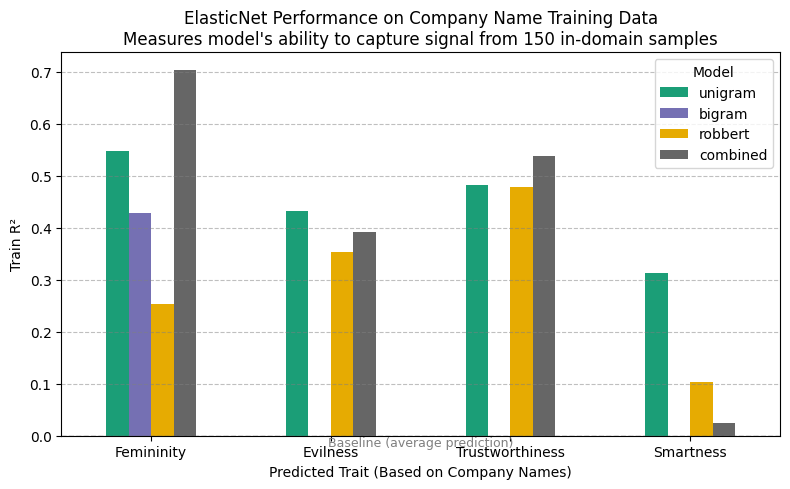

✅ CV R² chart saved to: C:\github\thesis\data\models\model_200company_only\cv_r2_by_model.png


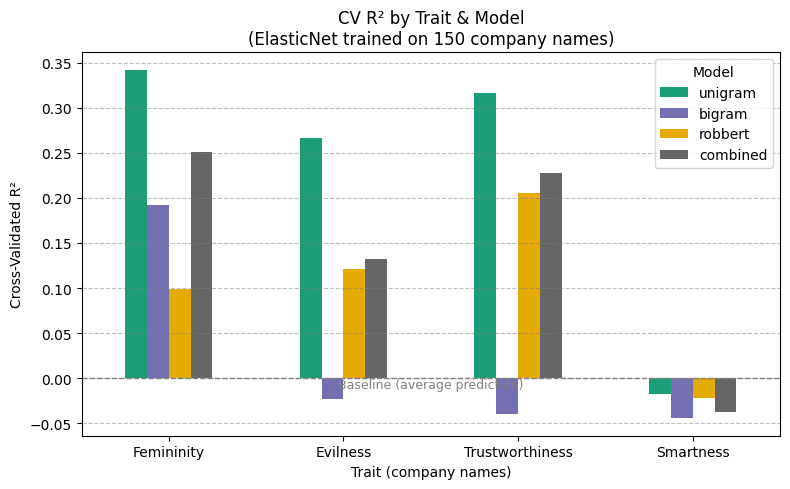

✅ Test R² chart saved to: C:\github\thesis\data\models\model_200company_only\test_r2_by_model.png


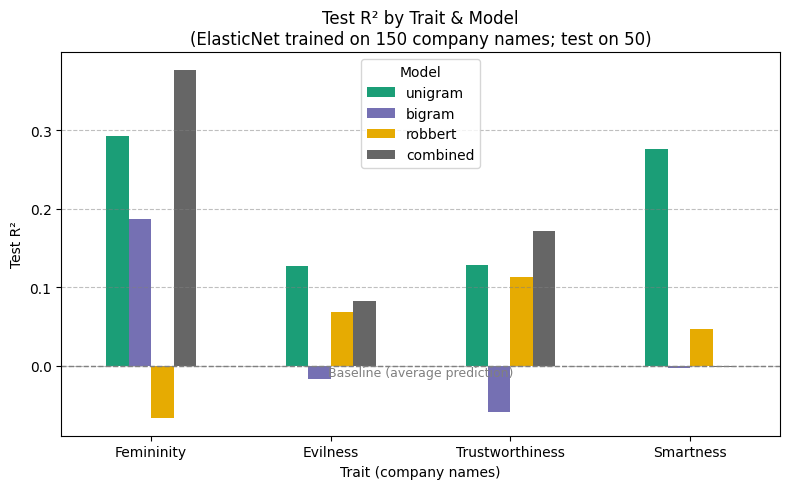

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── Configuration ──────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\github\thesis\data"
MODELS_DIR  = os.path.join(BASE_DIR, "models", "model_200company_only")
COMBINED_CSV= os.path.join(MODELS_DIR, "all_models_metrics.csv")

# ── Load combined metrics ───────────────────────────────────────────────────────
combined = pd.read_csv(COMBINED_CSV)

# Display combined metrics
print("✅ Combined metrics:")
print(combined)

# ── Prepare data for plotting with specified order ──────────────────────────────
trait_order = ["feminine", "evil", "trustworthy", "smart"]
model_order = ["unigram", "bigram", "robbert", "combined"]

display_names = {
    "feminine": "Femininity",
    "evil": "Evilness",
    "trustworthy": "Trustworthiness",
    "smart": "Smartness",
}

pivot_train = (
    combined
    .pivot(index="trait", columns="model", values="train_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_cv = (
    combined
    .pivot(index="trait", columns="model", values="cv_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_test = (
    combined
    .pivot(index="trait", columns="model", values="test_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)

# ── Pull in std for test error bars only (if exists) ───────────────────────────
if "test_r2_std" in combined.columns:
    pivot_test_std = (
        combined
        .pivot(index="trait", columns="model", values="test_r2_std")
        .loc[trait_order, model_order]
        .rename(index=display_names)
    )
else:
    pivot_test_std = pivot_test * 0.0

# ── Helper to polish charts and annotate average line ───────────────────────────
def polish(ax):
    # Draw average line at R² = 0
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    
    # Annotate the line: horizontally centered, vertically under the line
    xlim = ax.get_xlim()
    mid = (xlim[0] + xlim[1]) / 2
    ax.text(mid, 0, 'Baseline (average prediction)', 
            ha='center', va='top', color='gray', fontsize=9)

    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()


# ── Plot Clean Train R² Chart ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))
pivot_train.plot(kind="bar", ax=ax, colormap="Dark2")

ax.set_xlabel("Predicted Trait (Based on Company Names)")
ax.set_ylabel("Train R²")
ax.set_title(
    "ElasticNet Performance on Company Name Training Data\n"
    "Measures model's ability to capture signal from 150 in-domain samples"
)

ax.legend(title="Model", loc="best")

# Polish visuals
polish(ax)

# Save and show
train_plot = os.path.join(MODELS_DIR, "train_r2_by_model.png")
fig.savefig(train_plot, bbox_inches="tight")
print(f"✅ Train R² chart saved to: {train_plot}")
plt.show()



# ── Plot CV R² ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_cv.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (company names)")
ax.set_ylabel("Cross-Validated R²")
ax.set_title("CV R² by Trait & Model\n(ElasticNet trained on 150 company names)")
ax.legend(title="Model", loc='best')
polish(ax)
cv_plot = os.path.join(MODELS_DIR, "cv_r2_by_model.png")
fig.savefig(cv_plot)
print(f"✅ CV R² chart saved to: {cv_plot}")
plt.show()

# ── Plot Test R² with error bars ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_test.plot(
    kind="bar",
    ax=ax,
    colormap='Dark2',
    yerr=pivot_test_std,
)
ax.set_xlabel("Trait (company names)")
ax.set_ylabel("Test R²")
ax.set_title("Test R² by Trait & Model\n(ElasticNet trained on 150 company names; test on 50)")
ax.legend(title="Model", loc='best')
polish(ax)
test_plot = os.path.join(MODELS_DIR, "test_r2_by_model.png")
fig.savefig(test_plot)
print(f"✅ Test R² chart saved to: {test_plot}")
plt.show()


In [ ]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import ElasticNet
from sklearn.pipeline         import Pipeline
from sklearn.model_selection  import GridSearchCV, StratifiedKFold
from sklearn.metrics          import r2_score, mean_squared_error
import joblib

# ── Paths ──────────────────────────────────────────────────────────────────────
base_dir  = "C:/github/thesis/data"
fv_dir    = os.path.join(base_dir, "feature_vectors")
split_dir = os.path.join(base_dir, "splits", "model_400pseudo_0company_test200")
models_dir = os.path.join(base_dir, "models", "model_400pseudo_0company_test200")
os.makedirs(models_dir, exist_ok=True)

# ── Hyperparameter grid & CV splitter ─────────────────────────────────────────
param_grid = {
    "model__alpha":    [0.01, 0.05, 0.1, 0.2, 1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Load JSONs for base feature sets ───────────────────────────────────────────
uni_data  = json.load(open(os.path.join(fv_dir, "unigram_feature_vectors.json"), "r", encoding="utf-8"))
bi_data   = json.load(open(os.path.join(fv_dir, "bigram_feature_vectors.json"),   "r", encoding="utf-8"))
rob_data  = json.load(open(os.path.join(fv_dir, "robbert_feature_vectors.json"),  "r", encoding="utf-8"))

# extract vectors & feature names
uni_vecs  = uni_data["vectors"];  unigrams  = uni_data["vocab"]
bi_vecs   = bi_data["vectors"];   bigrams   = bi_data["vocab"]
rob_vecs  = rob_data["vectors"]
n_dims    = len(next(iter(rob_vecs.values())))
rob_dims  = [f"dim_{i}" for i in range(n_dims)]

# Define all four feature‐set configs
feature_sets = {
    "unigram": {
        "build": lambda words: np.vstack([uni_vecs[w.lower()] for w in words]),
        "names": unigrams
    },
    "bigram": {
        "build": lambda words: np.vstack([bi_vecs[w.lower()]  for w in words]),
        "names": bigrams
    },
    "robbert": {
        "build": lambda words: np.vstack([rob_vecs[w.lower()] for w in words]),
        "names": rob_dims
    },
    "combined": {
        "build": lambda words: np.hstack([
            np.vstack([uni_vecs[w.lower()] for w in words]),
            np.vstack([bi_vecs[w.lower()]  for w in words]),
            np.vstack([rob_vecs[w.lower()] for w in words])
        ]),
        "names": unigrams + bigrams + rob_dims
    }
}

traits = ["feminine", "evil", "trustworthy", "smart"]

# ── Loop through each feature set ──────────────────────────────────────────────
for feat_name, cfg in feature_sets.items():
    out_dir = os.path.join(models_dir, f"{feat_name}_elasticnet")
    os.makedirs(out_dir, exist_ok=True)

    records = []
    for tr in traits:
        # load train/test
        train_df = pd.read_csv(os.path.join(split_dir, f"train_{tr}.csv"))
        test_df  = pd.read_csv(os.path.join(split_dir, f"test_{tr}.csv"))

        # build X & y
        X_train = cfg["build"](train_df["word"])
        X_test  = cfg["build"](test_df["word"])
        y_train = train_df["average_rating"].values
        y_test  = test_df["average_rating"].values

        # stratify by domain type
        domain_labels = train_df["type"].map({"pseudo":0, "name":1}).values

        # pipeline + grid
        pipeline = Pipeline([
            ("scale", StandardScaler()),
            ("model", ElasticNet(max_iter=5000))
        ])
        grid = GridSearchCV(
            pipeline, param_grid,
            cv=skf.split(X_train, domain_labels),
            scoring="r2", n_jobs=-1, error_score=np.nan
        )
        grid.fit(X_train, y_train)

        best   = grid.best_estimator_
        params = grid.best_params_
        cv_r2  = grid.best_score_

        # feature importances
        coefs = best.named_steps["model"].coef_
        imp_df = pd.DataFrame({
            feat_name:     cfg["names"],
            "coefficient": coefs
        })
        imp_df["abs_importance"] = imp_df["coefficient"].abs()
        imp_df = (
            imp_df[imp_df["coefficient"] != 0]
            .sort_values("abs_importance", ascending=False)
        )
        imp_df.to_csv(os.path.join(out_dir, f"{tr}_{feat_name}_importances.csv"), index=False)

        # evaluate
        y_tr = best.predict(X_train)
        y_te = best.predict(X_test)
        train_r2  = r2_score(y_train, y_tr)
        train_mse = mean_squared_error(y_train, y_tr)
        test_r2   = r2_score(y_test,  y_te)
        test_mse  = mean_squared_error(y_test,  y_te)

        # record + save model
        records.append({
            "model":         feat_name,
            "trait":         tr,
            "best_alpha":    params["model__alpha"],
            "best_l1_ratio": params["model__l1_ratio"],
            "cv_r2":         cv_r2,
            "train_r2":      train_r2,
            "train_mse":     train_mse,
            "test_r2":       test_r2,
            "test_mse":      test_mse,
            "num_selected":  int((coefs != 0).sum())
        })
        joblib.dump(best, os.path.join(out_dir, f"{tr}_{feat_name}_elasticnet.pkl"))

    # save & print
    metrics_df = pd.DataFrame(records)
    metrics_df.to_csv(os.path.join(out_dir, f"{feat_name}_elasticnet_metrics.csv"), index=False)
    print(f"✅ {feat_name.capitalize()} ElasticNet complete. Metrics:")
    print(metrics_df)


✅ Unigram ElasticNet complete. Metrics:
     model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  unigram     feminine        0.20            0.1  0.014720  0.147400   
1  unigram         evil        0.05            0.1  0.066337  0.176814   
2  unigram  trustworthy        0.20            0.1 -0.012014  0.041829   
3  unigram        smart        0.05            0.7  0.028069  0.067366   

   train_mse   test_r2  test_mse  num_selected  
0   0.709230  0.131728  0.255800            23  
1   0.134234  0.098568  0.089818            26  
2   0.083528 -0.001242  0.134713             9  
3   0.111053  0.046835  0.106457             4  
✅ Bigram ElasticNet complete. Metrics:
    model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  bigram     feminine        0.10            0.9  0.200916  0.277375   
1  bigram         evil        0.05            0.7  0.044419  0.206684   
2  bigram  trustworthy        0.05            0.9  0.005492  0.042999   
3  bigram    

✅ Loaded existing combined metrics CSV:
  C:\github\thesis\data\models\model_400pseudo_0company_test200\all_models_metrics.csv

✅ Combined metrics:
       model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0     bigram     feminine        0.10            0.9  0.200916  0.277375   
1     bigram         evil        0.05            0.7  0.044419  0.206684   
2     bigram  trustworthy        0.05            0.9  0.005492  0.042999   
3     bigram        smart        0.05            0.7 -0.004178  0.140317   
4   combined     feminine        0.10            0.9  0.213815  0.354040   
5   combined         evil        0.10            0.3  0.137683  0.405564   
6   combined  trustworthy        0.10            0.3  0.026237  0.192176   
7   combined        smart        0.05            0.7  0.029056  0.214977   
8    robbert     feminine        0.20            0.3  0.064204  0.321434   
9    robbert         evil        0.05            0.7  0.110229  0.266929   
10   robbert  tr

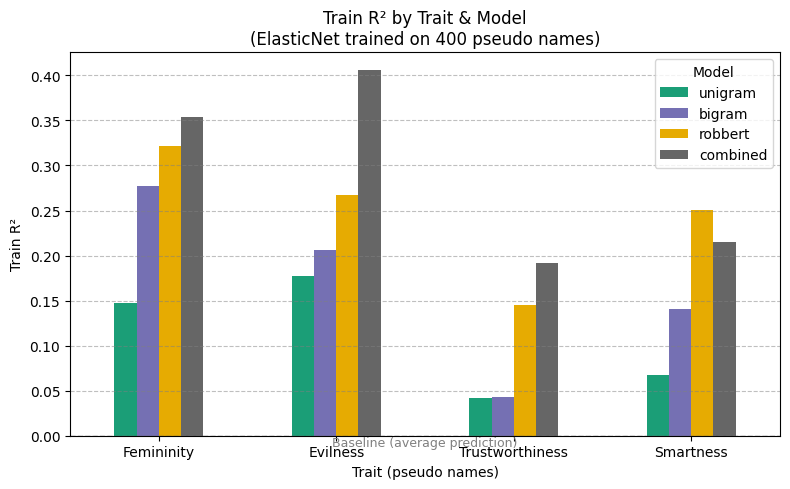

✅ CV R² chart saved to: C:\github\thesis\data\models\model_400pseudo_0company_test200\cv_r2_by_model.png


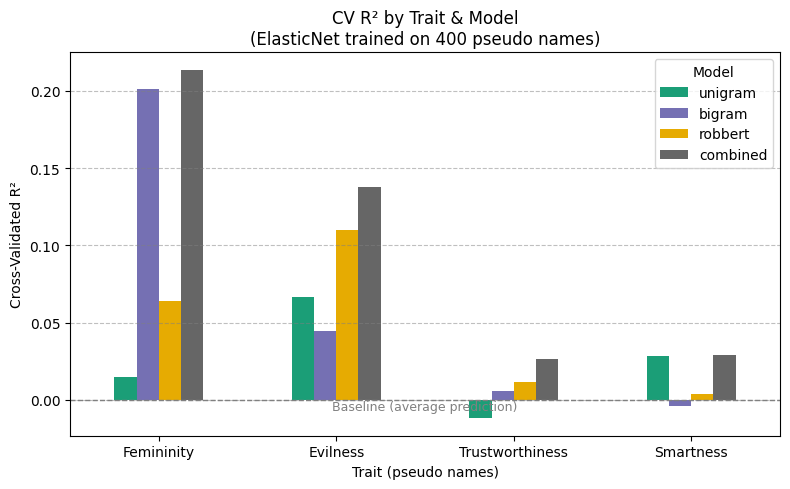

✅ Test R² chart saved to: C:\github\thesis\data\models\model_400pseudo_0company_test200\model2_test_r2_by_model.png


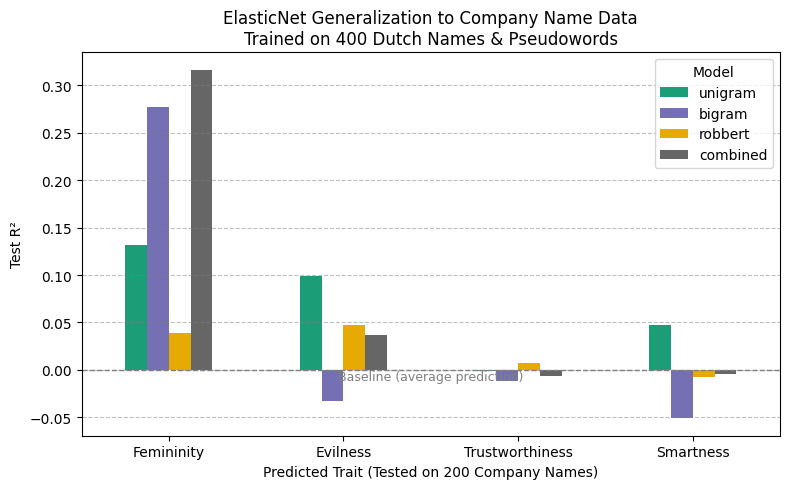

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── Configuration ──────────────────────────────────────────────────────────────
MODELS_DIR   = r"C:\github\thesis\data\models\model_400pseudo_0company_test200"
FEATURES     = ["unigram", "bigram", "robbert", "combined"]
COMBINED_CSV = os.path.join(MODELS_DIR, "all_models_metrics.csv")

# ── Load or Create Combined Metrics ─────────────────────────────────────────────
if not os.path.exists(COMBINED_CSV):
    dfs = []
    for feat in FEATURES:
        folder = os.path.join(MODELS_DIR, f"{feat}_elasticnet")
        filename = f"{feat}_elasticnet_metrics.csv"
        path = os.path.join(folder, filename)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing metrics for '{feat}':\n  {path}")
        df = pd.read_csv(path)
        df["model"] = feat
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(COMBINED_CSV, index=False)
    print(f"✅ Created combined metrics CSV:\n  {COMBINED_CSV}")
else:
    combined = pd.read_csv(COMBINED_CSV)
    print(f"✅ Loaded existing combined metrics CSV:\n  {COMBINED_CSV}")

# ── Display combined metrics ───────────────────────────────────────────────────
print("\n✅ Combined metrics:")
print(combined)

# ── Prepare data for plotting ──────────────────────────────────────────────────
trait_order = ["feminine", "evil", "trustworthy", "smart"]
model_order = ["unigram", "bigram", "robbert", "combined"]
display_names = {
    "feminine": "Femininity",
    "evil": "Evilness",
    "trustworthy": "Trustworthiness",
    "smart": "Smartness",
}

pivot_train = (
    combined
    .pivot(index="trait", columns="model", values="train_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_cv = (
    combined
    .pivot(index="trait", columns="model", values="cv_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_test = (
    combined
    .pivot(index="trait", columns="model", values="test_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)

# ── Pull in std for test error bars only (if exists) ───────────────────────────
if "test_r2_std" in combined.columns:
    pivot_test_std = (
        combined
        .pivot(index="trait", columns="model", values="test_r2_std")
        .loc[trait_order, model_order]
        .rename(index=display_names)
    )
else:
    pivot_test_std = pivot_test * 0.0

# ── Helper to polish charts and annotate average line ───────────────────────────
def polish(ax):
    # Draw average line at R² = 0
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    
    # Annotate the line: horizontally centered, vertically under the line
    xlim = ax.get_xlim()
    mid = (xlim[0] + xlim[1]) / 2
    ax.text(mid, 0, 'Baseline (average prediction)', 
            ha='center', va='top', color='gray', fontsize=9)

    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()

# ── Plot Train R² ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_train.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (pseudo names)")
ax.set_ylabel("Train R²")
ax.set_title("Train R² by Trait & Model\n(ElasticNet trained on 400 pseudo names)")
ax.legend(title="Model", loc='best')
polish(ax)
train_plot = os.path.join(MODELS_DIR, "train_r2_by_model.png")
fig.savefig(train_plot)
print(f"✅ Train R² chart saved to: {train_plot}")
plt.show()

# ── Plot CV R² ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_cv.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (pseudo names)")
ax.set_ylabel("Cross-Validated R²")
ax.set_title("CV R² by Trait & Model\n(ElasticNet trained on 400 pseudo names)")
ax.legend(title="Model", loc='best')
polish(ax)
cv_plot = os.path.join(MODELS_DIR, "cv_r2_by_model.png")
fig.savefig(cv_plot)
print(f"✅ CV R² chart saved to: {cv_plot}")
plt.show()

# ── Plot Clean Test R² Chart (Model 2) ──────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))
pivot_test.plot(kind="bar", ax=ax, colormap="Dark2", yerr=pivot_test_std)

ax.set_xlabel("Predicted Trait (Tested on 200 Company Names)")
ax.set_ylabel("Test R²")
ax.set_title(
    "ElasticNet Generalization to Company Name Data\n"
    "Trained on 400 Dutch Names & Pseudowords"
)

ax.legend(title="Model", loc="best")

# Polish visuals
polish(ax)

# Save and show
test_plot = os.path.join(MODELS_DIR, "model2_test_r2_by_model.png")
fig.savefig(test_plot, bbox_inches="tight")
print(f"✅ Test R² chart saved to: {test_plot}")
plt.show()




In [63]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import ElasticNet
from sklearn.pipeline         import Pipeline
from sklearn.model_selection  import GridSearchCV, StratifiedKFold
from sklearn.metrics          import r2_score, mean_squared_error
import joblib

# ── Paths ──────────────────────────────────────────────────────────────────────
base_dir   = r"C:\github\thesis\data"
split_dir  = os.path.join(base_dir, "splits", "model_400pseudo_100company_test100")
models_dir = os.path.join(base_dir, "models", "model_400pseudo_100company_test100")
fv_dir     = os.path.join(base_dir, "feature_vectors")
os.makedirs(models_dir, exist_ok=True)

# ── Hyperparameter grid & CV ───────────────────────────────────────────────────
param_grid = {
    "model__alpha":    [0.01, 0.05, 0.1, 0.2, 1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Load feature JSONs ──────────────────────────────────────────────────────────
uni_data  = json.load(open(os.path.join(fv_dir, "unigram_feature_vectors.json"), "r", encoding="utf-8"))
bi_data   = json.load(open(os.path.join(fv_dir, "bigram_feature_vectors.json"),  "r", encoding="utf-8"))
rob_data  = json.load(open(os.path.join(fv_dir, "robbert_feature_vectors.json"), "r", encoding="utf-8"))

uni_vecs  = uni_data["vectors"];  unigrams  = uni_data["vocab"]
bi_vecs   = bi_data["vectors"];   bigrams   = bi_data["vocab"]
rob_vecs  = rob_data["vectors"]
n_dims    = len(next(iter(rob_vecs.values())))
rob_dims  = [f"dim_{i}" for i in range(n_dims)]

# ── Feature‐set definitions ─────────────────────────────────────────────────────
feature_sets = {
    "unigram": {
        "build": lambda words: np.vstack([uni_vecs[w.lower()] for w in words]),
        "names": unigrams
    },
    "bigram": {
        "build": lambda words: np.vstack([bi_vecs[w.lower()]  for w in words]),
        "names": bigrams
    },
    "robbert": {
        "build": lambda words: np.vstack([rob_vecs[w.lower()] for w in words]),
        "names": rob_dims
    },
    "combined": {
        "build": lambda words: np.hstack([
            np.vstack([uni_vecs[w.lower()] for w in words]),
            np.vstack([bi_vecs[w.lower()]  for w in words]),
            np.vstack([rob_vecs[w.lower()] for w in words])
        ]),
        "names": unigrams + bigrams + rob_dims
    }
}

traits = ["feminine", "evil", "trustworthy", "smart"]

# ── Main loop: one folder per feature set ───────────────────────────────────────
for feat_name, cfg in feature_sets.items():
    out_dir = os.path.join(models_dir, f"{feat_name}_elasticnet")
    os.makedirs(out_dir, exist_ok=True)
    records = []

    for tr in traits:
        # Load split CSVs
        train_df = pd.read_csv(os.path.join(split_dir, f"train_{tr}.csv"))
        test_df  = pd.read_csv(os.path.join(split_dir, f"test_{tr}.csv"))

        # Build feature matrices & targets
        X_train = cfg["build"](train_df["word"])
        X_test  = cfg["build"](test_df["word"])
        y_train = train_df["average_rating"].values
        y_test  = test_df["average_rating"].values

        # Stratification labels (0=pseudo, 1=name/company)
        domain_labels = train_df["type"].map({"pseudo":0, "name":1, "company":2}).values

        # Pipeline + GridSearchCV
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", ElasticNet(max_iter=5000))])
        grid = GridSearchCV(pipe, param_grid,
                            cv=skf.split(X_train, domain_labels),
                            scoring="r2", n_jobs=-1, error_score=np.nan)
        grid.fit(X_train, y_train)

        best   = grid.best_estimator_
        params = grid.best_params_
        cv_r2  = grid.best_score_

        # Extract non-zero coefficients
        coefs = best.named_steps["model"].coef_
        imp_df = pd.DataFrame({
            feat_name:     cfg["names"],
            "coefficient": coefs
        })
        imp_df["abs_importance"] = imp_df["coefficient"].abs()
        imp_df = (
            imp_df[imp_df["coefficient"] != 0]
            .sort_values("abs_importance", ascending=False)
        )
        imp_df.to_csv(os.path.join(out_dir, f"{tr}_{feat_name}_importances.csv"),
                      index=False)

        # Evaluate on training & test
        y_tr = best.predict(X_train)
        y_te = best.predict(X_test)
        train_r2, train_mse = r2_score(y_train, y_tr), mean_squared_error(y_train, y_tr)
        test_r2,  test_mse  = r2_score(y_test,  y_te), mean_squared_error(y_test,  y_te)

        # Record metrics + save model
        records.append({
            "model":         feat_name,
            "trait":         tr,
            "best_alpha":    params["model__alpha"],
            "best_l1_ratio": params["model__l1_ratio"],
            "cv_r2":         cv_r2,
            "train_r2":      train_r2,
            "train_mse":     train_mse,
            "test_r2":       test_r2,
            "test_mse":      test_mse,
            "num_selected":  int((coefs != 0).sum())
        })
        joblib.dump(best, os.path.join(out_dir, f"{tr}_{feat_name}_elasticnet.pkl"))

    # Save per‐feature metrics
    metrics_df = pd.DataFrame(records)
    metrics_df.to_csv(os.path.join(out_dir, f"{feat_name}_elasticnet_metrics.csv"), index=False)
    print(f"✅ {feat_name.capitalize()} ElasticNet done. Metrics:")
    print(metrics_df)


✅ Unigram ElasticNet done. Metrics:
     model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  unigram     feminine        0.10            0.1  0.063654  0.162853   
1  unigram         evil        0.05            0.1  0.091365  0.171725   
2  unigram  trustworthy        0.05            0.1  0.050928  0.141257   
3  unigram        smart        0.10            0.1  0.050315  0.148507   

   train_mse   test_r2  test_mse  num_selected  
0   0.602622  0.212384  0.248703            25  
1   0.121190  0.185393  0.097646            24  
2   0.083901  0.172204  0.106993            22  
3   0.097923  0.155507  0.105220            18  
✅ Bigram ElasticNet done. Metrics:
    model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  bigram     feminine        0.10            0.5  0.219940  0.389760   
1  bigram         evil        0.05            0.9  0.017446  0.079954   
2  bigram  trustworthy        0.05            0.9 -0.002843  0.016214   
3  bigram        smar

✅ Loaded existing combined metrics CSV:
  C:\github\thesis\data\models\model_400pseudo_100company_test100\all_models_metrics.csv

✅ Combined metrics:
       model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0    unigram     feminine        0.10            0.1  0.063654  0.162853   
1    unigram         evil        0.05            0.1  0.091365  0.171725   
2    unigram  trustworthy        0.05            0.1  0.050928  0.141257   
3    unigram        smart        0.10            0.1  0.050315  0.148507   
4     bigram     feminine        0.10            0.5  0.219940  0.389760   
5     bigram         evil        0.05            0.9  0.017446  0.079954   
6     bigram  trustworthy        0.05            0.9 -0.002843  0.016214   
7     bigram        smart        0.05            0.9 -0.012877  0.012128   
8    robbert     feminine        0.20            0.3  0.092552  0.258841   
9    robbert         evil        0.05            0.7  0.111207  0.216705   
10   robbert  

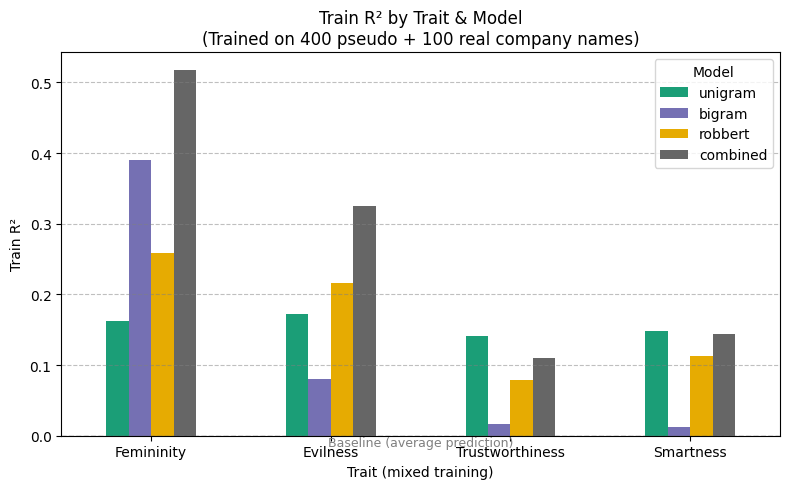

✅ CV R² chart saved to: C:\github\thesis\data\models\model_400pseudo_100company_test100\cv_r2_by_model.png


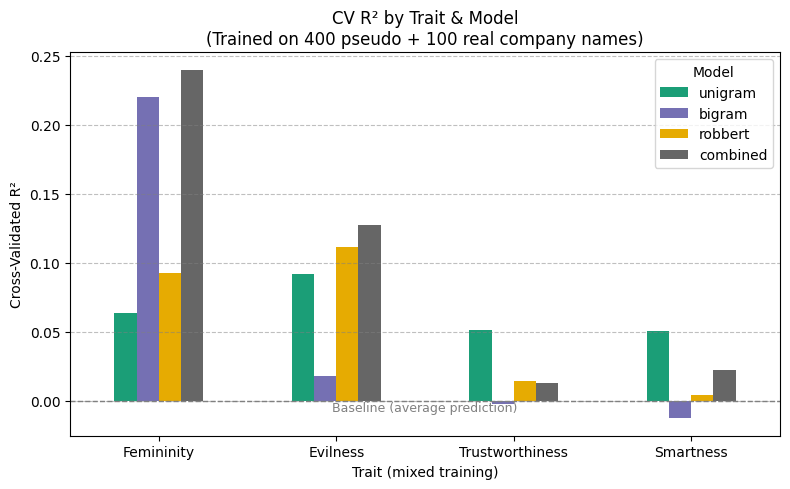

✅ Test R² chart saved to: C:\github\thesis\data\models\model_400pseudo_100company_test100\model3_test_r2_by_model.png


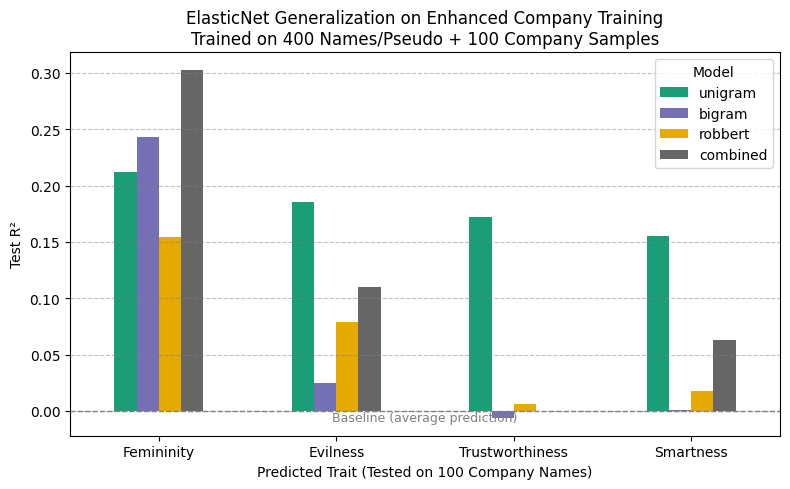

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── Configuration ──────────────────────────────────────────────────────────────
MODELS_DIR   = r"C:\github\thesis\data\models\model_400pseudo_100company_test100"
FEATURES     = ["unigram", "bigram", "robbert", "combined"]
COMBINED_CSV = os.path.join(MODELS_DIR, "all_models_metrics.csv")

# ── Load or create combined CSV ────────────────────────────────────────────────
if not os.path.exists(COMBINED_CSV):
    dfs = []
    for feat in FEATURES:
        folder = os.path.join(MODELS_DIR, f"{feat}_elasticnet")
        metrics_path = os.path.join(folder, f"{feat}_elasticnet_metrics.csv")
        if not os.path.exists(metrics_path):
            raise FileNotFoundError(f"Missing metrics for '{feat}':\n  {metrics_path}")
        tmp = pd.read_csv(metrics_path)
        tmp["model"] = feat
        dfs.append(tmp)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(COMBINED_CSV, index=False)
    print(f"✅ Created combined metrics CSV:\n  {COMBINED_CSV}")
else:
    combined = pd.read_csv(COMBINED_CSV)
    print(f"✅ Loaded existing combined metrics CSV:\n  {COMBINED_CSV}")

# ── Show combined dataframe ────────────────────────────────────────────────────
print("\n✅ Combined metrics:")
print(combined)

# ── Define trait/model orders and display names ────────────────────────────────
trait_order = ["feminine", "evil", "trustworthy", "smart"]
model_order = ["unigram", "bigram", "robbert", "combined"]
display_names = {
    "feminine": "Femininity",
    "evil": "Evilness",
    "trustworthy": "Trustworthiness",
    "smart": "Smartness",
}

# ── Create pivot tables ────────────────────────────────────────────────────────
pivot_train = (
    combined
    .pivot(index="trait", columns="model", values="train_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_cv = (
    combined
    .pivot(index="trait", columns="model", values="cv_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_test = (
    combined
    .pivot(index="trait", columns="model", values="test_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)

# ── Pull in test R² std if available ───────────────────────────────────────────
if "test_r2_std" in combined.columns:
    pivot_test_std = (
        combined
        .pivot(index="trait", columns="model", values="test_r2_std")
        .loc[trait_order, model_order]
        .rename(index=display_names)
    )
else:
    pivot_test_std = pivot_test * 0.0

# ── Helper to polish charts and annotate baseline ──────────────────────────────
def polish(ax):
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    xlim = ax.get_xlim()
    mid = (xlim[0] + xlim[1]) / 2
    ax.text(mid, 0, 'Baseline (average prediction)',
            ha='center', va='top', color='gray', fontsize=9)
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()

# ── Plot Train R² ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_train.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (mixed training)")
ax.set_ylabel("Train R²")
ax.set_title("Train R² by Trait & Model\n(Trained on 400 pseudo + 100 real company names)")
ax.legend(title="Model", loc='best')
polish(ax)
train_plot = os.path.join(MODELS_DIR, "train_r2_by_model.png")
fig.savefig(train_plot)
print(f"✅ Train R² chart saved to: {train_plot}")
plt.show()

# ── Plot CV R² ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_cv.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (mixed training)")
ax.set_ylabel("Cross-Validated R²")
ax.set_title("CV R² by Trait & Model\n(Trained on 400 pseudo + 100 real company names)")
ax.legend(title="Model", loc='best')
polish(ax)
cv_plot = os.path.join(MODELS_DIR, "cv_r2_by_model.png")
fig.savefig(cv_plot)
print(f"✅ CV R² chart saved to: {cv_plot}")
plt.show()

# ── Plot Clean Test R² Chart (Model 3) ──────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))
pivot_test.plot(kind="bar", ax=ax, colormap="Dark2", yerr=pivot_test_std)

ax.set_xlabel("Predicted Trait (Tested on 100 Company Names)")
ax.set_ylabel("Test R²")
ax.set_title(
    "ElasticNet Generalization on Enhanced Company Training\n"
    "Trained on 400 Names/Pseudo + 100 Company Samples"
)

ax.legend(title="Model", loc="best")

# Polish visuals
polish(ax)

# Save and show
test_plot = os.path.join(MODELS_DIR, "model3_test_r2_by_model.png")
fig.savefig(test_plot, bbox_inches="tight")
print(f"✅ Test R² chart saved to: {test_plot}")
plt.show()



In [88]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import ElasticNet
from sklearn.pipeline         import Pipeline
from sklearn.model_selection  import GridSearchCV, StratifiedKFold
from sklearn.metrics          import r2_score, mean_squared_error
import joblib

# ── Paths ──────────────────────────────────────────────────────────────────────
base_dir   = r"C:\github\thesis\data"
split_dir  = os.path.join(base_dir, "splits", "model_400pseudo_100company_test100")
models_dir = os.path.join(base_dir, "models", "model_400pseudo_100company4x_test100")
fv_dir     = os.path.join(base_dir, "feature_vectors")
os.makedirs(models_dir, exist_ok=True)

# ── Hyperparameter grid & CV ───────────────────────────────────────────────────
param_grid = {
    "model__alpha":    [0.01, 0.05, 0.1, 0.2, 1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Load feature JSONs ──────────────────────────────────────────────────────────
uni_data  = json.load(open(os.path.join(fv_dir, "unigram_feature_vectors.json"), "r", encoding="utf-8"))
bi_data   = json.load(open(os.path.join(fv_dir, "bigram_feature_vectors.json"),  "r", encoding="utf-8"))
rob_data  = json.load(open(os.path.join(fv_dir, "robbert_feature_vectors.json"), "r", encoding="utf-8"))

uni_vecs  = uni_data["vectors"];  unigrams  = uni_data["vocab"]
bi_vecs   = bi_data["vectors"];   bigrams   = bi_data["vocab"]
rob_vecs  = rob_data["vectors"]
n_dims    = len(next(iter(rob_vecs.values())))
rob_dims  = [f"dim_{i}" for i in range(n_dims)]

# ── Feature‐set definitions ─────────────────────────────────────────────────────
feature_sets = {
    "unigram": {
        "build": lambda words: np.vstack([uni_vecs[w.lower()] for w in words]),
        "names": unigrams
    },
    "bigram": {
        "build": lambda words: np.vstack([bi_vecs[w.lower()]  for w in words]),
        "names": bigrams
    },
    "robbert": {
        "build": lambda words: np.vstack([rob_vecs[w.lower()] for w in words]),
        "names": rob_dims
    },
    "combined": {
        "build": lambda words: np.hstack([
            np.vstack([uni_vecs[w.lower()] for w in words]),
            np.vstack([bi_vecs[w.lower()]  for w in words]),
            np.vstack([rob_vecs[w.lower()] for w in words])
        ]),
        "names": unigrams + bigrams + rob_dims
    }
}

traits = ["feminine", "evil", "trustworthy", "smart"]

# ── Main loop: one folder per feature set ───────────────────────────────────────
for feat_name, cfg in feature_sets.items():
    out_dir = os.path.join(models_dir, f"{feat_name}_elasticnet")
    os.makedirs(out_dir, exist_ok=True)
    records = []

    for tr in traits:
        # Load split CSVs
        train_df = pd.read_csv(os.path.join(split_dir, f"train_{tr}.csv"))
        test_df  = pd.read_csv(os.path.join(split_dir, f"test_{tr}.csv"))

        # ── 1. Duplicate company samples in training set ────────────────────────
        company_df = train_df[train_df["type"] == "company"]
        train_df_aug = pd.concat([train_df] + [company_df]*3, ignore_index=True)
        train_df_aug = train_df_aug.sample(frac=1.0, random_state=42).reset_index(drop=True)

        # ── 2. Build feature matrices & targets ─────────────────────────────────
        X_train = cfg["build"](train_df_aug["word"])
        X_test  = cfg["build"](test_df["word"])
        y_train = train_df_aug["average_rating"].values
        y_test  = test_df["average_rating"].values

        # Stratification labels (0=pseudo, 1=name, 2=company)
        domain_labels = train_df_aug["type"].map({"pseudo":0, "name":1, "company":2}).values

        # ── 3. Pipeline + GridSearchCV ─────────────────────────────────────────
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", ElasticNet(max_iter=5000))])
        grid = GridSearchCV(pipe, param_grid,
                            cv=skf.split(X_train, domain_labels),
                            scoring="r2", n_jobs=-1, error_score=np.nan)
        grid.fit(X_train, y_train)

        best   = grid.best_estimator_
        params = grid.best_params_
        cv_r2  = grid.best_score_

        # ── 4. Extract non-zero coefficients ───────────────────────────────────
        coefs = best.named_steps["model"].coef_
        imp_df = pd.DataFrame({
            feat_name:     cfg["names"],
            "coefficient": coefs
        })
        imp_df["abs_importance"] = imp_df["coefficient"].abs()
        imp_df = (
            imp_df[imp_df["coefficient"] != 0]
            .sort_values("abs_importance", ascending=False)
        )
        imp_df.to_csv(os.path.join(out_dir, f"{tr}_{feat_name}_importances.csv"),
                      index=False)

        # ── 5. Evaluate on training & test ─────────────────────────────────────
        y_tr = best.predict(X_train)
        y_te = best.predict(X_test)
        train_r2, train_mse = r2_score(y_train, y_tr), mean_squared_error(y_train, y_tr)
        test_r2,  test_mse  = r2_score(y_test,  y_te), mean_squared_error(y_test,  y_te)

        # ── 6. Record metrics + save model ─────────────────────────────────────
        records.append({
            "model":         feat_name,
            "trait":         tr,
            "best_alpha":    params["model__alpha"],
            "best_l1_ratio": params["model__l1_ratio"],
            "cv_r2":         cv_r2,
            "train_r2":      train_r2,
            "train_mse":     train_mse,
            "test_r2":       test_r2,
            "test_mse":      test_mse,
            "num_selected":  int((coefs != 0).sum())
        })
        joblib.dump(best, os.path.join(out_dir, f"{tr}_{feat_name}_elasticnet.pkl"))

    # Save per‐feature metrics
    metrics_df = pd.DataFrame(records)
    metrics_df.to_csv(os.path.join(out_dir, f"{feat_name}_elasticnet_metrics.csv"), index=False)
    print(f"✅ {feat_name.capitalize()} ElasticNet done. Metrics:")
    print(metrics_df)


✅ Unigram ElasticNet done. Metrics:
     model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  unigram     feminine        0.01            0.7  0.153010  0.215068   
1  unigram         evil        0.01            0.1  0.182514  0.231673   
2  unigram  trustworthy        0.01            0.1  0.235369  0.271627   
3  unigram        smart        0.01            0.3  0.160058  0.215017   

   train_mse   test_r2  test_mse  num_selected  
0   0.433017  0.264095  0.232374            25  
1   0.093108  0.194061  0.096607            27  
2   0.082663  0.250794  0.096836            26  
3   0.085472  0.208511  0.098616            25  
✅ Bigram ElasticNet done. Metrics:
    model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0  bigram     feminine        0.05            0.5  0.338374  0.552923   
1  bigram         evil        0.10            0.1  0.208212  0.534428   
2  bigram  trustworthy        0.10            0.1  0.337345  0.584568   
3  bigram        smar

feed foward model


✅ Loaded existing combined metrics CSV:
  C:\github\thesis\data\models\model_400pseudo_100company4x_test100\all_models_metrics.csv

✅ Combined metrics:
       model        trait  best_alpha  best_l1_ratio     cv_r2  train_r2  \
0    unigram     feminine        0.01            0.7  0.153010  0.215068   
1    unigram         evil        0.01            0.1  0.182514  0.231673   
2    unigram  trustworthy        0.01            0.1  0.235369  0.271627   
3    unigram        smart        0.01            0.3  0.160058  0.215017   
4     bigram     feminine        0.05            0.5  0.338374  0.552923   
5     bigram         evil        0.10            0.1  0.208212  0.534428   
6     bigram  trustworthy        0.10            0.1  0.337345  0.584568   
7     bigram        smart        0.10            0.1  0.254618  0.540829   
8    robbert     feminine        0.10            0.1  0.233639  0.561538   
9    robbert         evil        0.10            0.1  0.246106  0.435271   
10   robbert

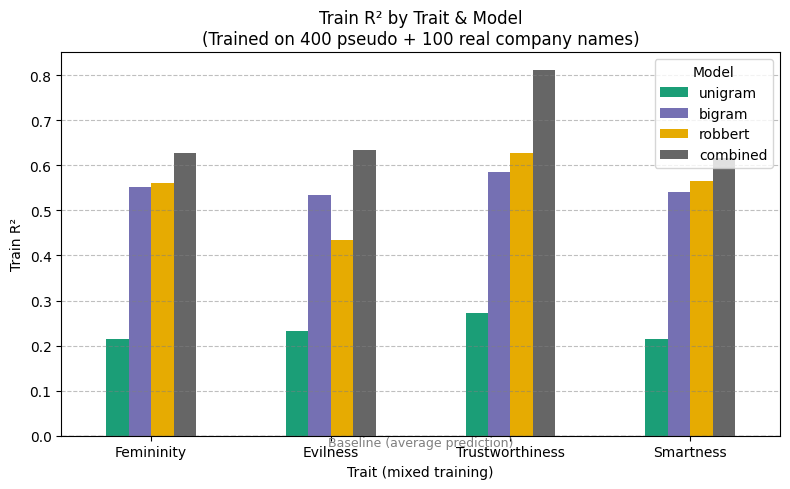

✅ CV R² chart saved to: C:\github\thesis\data\models\model_400pseudo_100company4x_test100\cv_r2_by_model.png


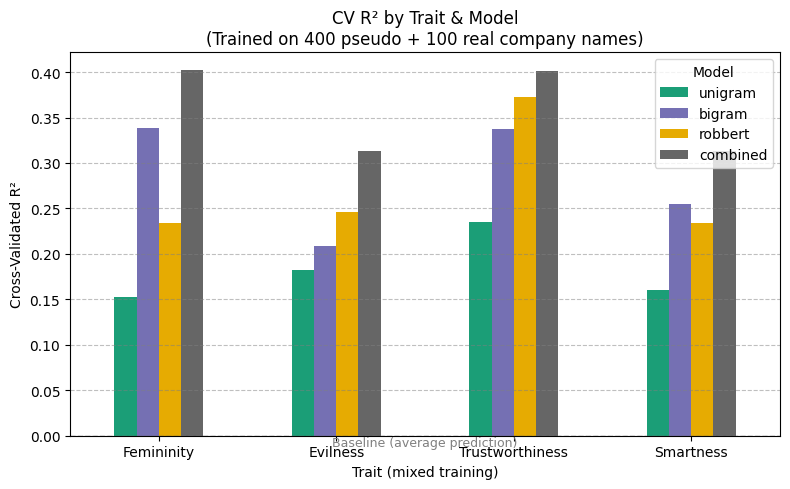

✅ Test R² chart saved to: C:\github\thesis\data\models\model_400pseudo_100company4x_test100\model3_test_r2_by_model.png


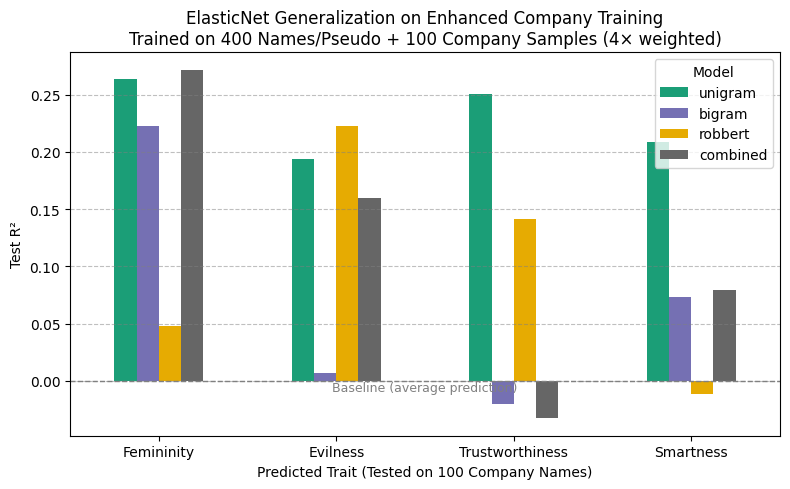

In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── Configuration ──────────────────────────────────────────────────────────────
MODELS_DIR   = r"C:\github\thesis\data\models\model_400pseudo_100company4x_test100"
FEATURES     = ["unigram", "bigram",  "robbert", "combined"]
COMBINED_CSV = os.path.join(MODELS_DIR, "all_models_metrics.csv")

# ── Load or create combined CSV ────────────────────────────────────────────────
if not os.path.exists(COMBINED_CSV):
    dfs = []
    for feat in FEATURES:
        folder = os.path.join(MODELS_DIR, f"{feat}_elasticnet")
        metrics_path = os.path.join(folder, f"{feat}_elasticnet_metrics.csv")
        if not os.path.exists(metrics_path):
            raise FileNotFoundError(f"Missing metrics for '{feat}':\n  {metrics_path}")
        tmp = pd.read_csv(metrics_path)
        tmp["model"] = feat
        dfs.append(tmp)
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(COMBINED_CSV, index=False)
    print(f"✅ Created combined metrics CSV:\n  {COMBINED_CSV}")
else:
    combined = pd.read_csv(COMBINED_CSV)
    print(f"✅ Loaded existing combined metrics CSV:\n  {COMBINED_CSV}")

# ── Show combined dataframe ────────────────────────────────────────────────────
print("\n✅ Combined metrics:")
print(combined)

# ── Define trait/model orders and display names ────────────────────────────────
trait_order = ["feminine", "evil", "trustworthy", "smart"]
model_order = ["unigram", "bigram", "robbert", "combined"]
display_names = {
    "feminine": "Femininity",
    "evil": "Evilness",
    "trustworthy": "Trustworthiness",
    "smart": "Smartness",
}

# ── Create pivot tables ────────────────────────────────────────────────────────
pivot_train = (
    combined
    .pivot(index="trait", columns="model", values="train_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_cv = (
    combined
    .pivot(index="trait", columns="model", values="cv_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)
pivot_test = (
    combined
    .pivot(index="trait", columns="model", values="test_r2")
    .loc[trait_order, model_order]
    .rename(index=display_names)
)

# ── Pull in test R² std if available ───────────────────────────────────────────
if "test_r2_std" in combined.columns:
    pivot_test_std = (
        combined
        .pivot(index="trait", columns="model", values="test_r2_std")
        .loc[trait_order, model_order]
        .rename(index=display_names)
    )
else:
    pivot_test_std = pivot_test * 0.0

# ── Helper to polish charts and annotate baseline ──────────────────────────────
def polish(ax):
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    xlim = ax.get_xlim()
    mid = (xlim[0] + xlim[1]) / 2
    ax.text(mid, 0, 'Baseline (average prediction)',
            ha='center', va='top', color='gray', fontsize=9)
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()

# ── Plot Train R² ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_train.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (mixed training)")
ax.set_ylabel("Train R²")
ax.set_title("Train R² by Trait & Model\n(Trained on 400 pseudo + 100 real company names)")
ax.legend(title="Model", loc='best')
polish(ax)
train_plot = os.path.join(MODELS_DIR, "train_r2_by_model.png")
fig.savefig(train_plot)
print(f"✅ Train R² chart saved to: {train_plot}")
plt.show()

# ── Plot CV R² ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
pivot_cv.plot(kind="bar", ax=ax, colormap='Dark2')
ax.set_xlabel("Trait (mixed training)")
ax.set_ylabel("Cross-Validated R²")
ax.set_title("CV R² by Trait & Model\n(Trained on 400 pseudo + 100 real company names)")
ax.legend(title="Model", loc='best')
polish(ax)
cv_plot = os.path.join(MODELS_DIR, "cv_r2_by_model.png")
fig.savefig(cv_plot)
print(f"✅ CV R² chart saved to: {cv_plot}")
plt.show()

# ── Plot Clean Test R² Chart (Model 3) ──────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))
pivot_test.plot(kind="bar", ax=ax, colormap="Dark2", yerr=pivot_test_std)

ax.set_xlabel("Predicted Trait (Tested on 100 Company Names)")
ax.set_ylabel("Test R²")
ax.set_title(
    "ElasticNet Generalization on Enhanced Company Training\n"
    "Trained on 400 Names/Pseudo + 100 Company Samples (4× weighted)"
)

ax.legend(title="Model", loc="best")

# Polish visuals
polish(ax)

# Save and show
test_plot = os.path.join(MODELS_DIR, "model3_test_r2_by_model.png")
fig.savefig(test_plot, bbox_inches="tight")
print(f"✅ Test R² chart saved to: {test_plot}")
plt.show()



In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ── Paths ──────────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\github\thesis\data"
CSV_DIR     = os.path.join(BASE_DIR, "output_json_by_trait", "trait_csvs")
SPLIT_DIR   = os.path.join(BASE_DIR, "splits", "model_400train_100valid_100test")
os.makedirs(SPLIT_DIR, exist_ok=True)

# ── Parameters ─────────────────────────────────────────────────────────────────
traits      = ["feminine", "evil", "trustworthy", "smart"]
RANDOM_SEED = 42

for trait in traits:
    # try loading either "<trait>_avg.csv" or "<trait>.csv"
    paths = [
        os.path.join(CSV_DIR, f"{trait}_avg.csv"),
        os.path.join(CSV_DIR, f"{trait}.csv")
    ]
    for p in paths:
        if os.path.exists(p):
            df = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError(f"Couldn't find either {paths!r}")

    # split out pseudo+name vs company
    pseudo_name_df = df[df["type"].isin(["pseudo","name"])].copy()
    company_df     = df[df["type"] == "company"].sample(frac=1, random_state=RANDOM_SEED)

    # train = all 400 pseudo+name
    train_df = pseudo_name_df

    # valid/test = split the 200 company names 50/50
    valid_df, test_df = train_test_split(
        company_df,
        test_size=0.5,
        random_state=RANDOM_SEED,
        shuffle=True
    )

    # save
    train_df.to_csv(os.path.join(SPLIT_DIR, f"train_{trait}.csv"), index=False)
    valid_df.to_csv(os.path.join(SPLIT_DIR, f"valid_{trait}.csv"), index=False)
    test_df.to_csv( os.path.join(SPLIT_DIR, f"test_{trait}.csv"),  index=False)

    print(f"Trait={trait:12s} → train:{len(train_df)}  valid:{len(valid_df)}  test:{len(test_df)}")


Trait=feminine     → train:400  valid:100  test:100
Trait=evil         → train:400  valid:100  test:100
Trait=trustworthy  → train:400  valid:100  test:100
Trait=smart        → train:400  valid:100  test:100


In [94]:
import os
import json
import unicodedata
import copy
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# ── Paths ───────────────────────────────────────────────────────────────────────
BASE       = r"C:\github\thesis\data"
FV_DIR     = os.path.join(BASE, "feature_vectors")
SPLIT_DIR  = os.path.join(BASE, "splits", "model_400train_100valid_100test")
MODEL_DIR  = os.path.join(BASE, "models", "model_ffnn_all_featuresets")
os.makedirs(MODEL_DIR, exist_ok=True)

# ── Load feature dicts ──────────────────────────────────────────────────────────
uni = json.load(open(os.path.join(FV_DIR, "unigram_feature_vectors.json")))
bi  = json.load(open(os.path.join(FV_DIR, "bigram_feature_vectors.json")))
rob = json.load(open(os.path.join(FV_DIR, "robbert_feature_vectors.json")))

uni_vecs = uni["vectors"]
bi_vecs  = bi["vectors"]
rob_vecs = rob["vectors"]

# ── Helper: normalize and fetch features ────────────────────────────────────────
def normalize_word(w: str) -> str:
    nfkd = unicodedata.normalize("NFKD", w.lower())
    return nfkd.encode("ascii", "ignore").decode("ascii")

def make_X(df, features="combined"):
    rows = []
    for w in df["word"]:
        wl = normalize_word(w)
        u = uni_vecs.get(wl, [0.0] * len(next(iter(uni_vecs.values()))))
        b = bi_vecs.get(wl, [0.0] * len(next(iter(bi_vecs.values()))))
        r = rob_vecs.get(wl, [0.0] * len(next(iter(rob_vecs.values()))))

        if features == "unigram":
            row = u
        elif features == "bigram":
            row = b
        elif features == "robbert":
            row = [r[i] for i in range(len(r))]
        elif features == "combined":
            row = u + b + r
        else:
            raise ValueError(f"Unknown feature set: {features}")

        rows.append(row)
    return np.array(rows)

# ── Settings ─────────────────────────────────────────────────────────────────────
traits = ["feminine", "evil", "trustworthy", "smart"]
feature_sets = ["unigram", "bigram", "robbert", "combined"]
hidden_sizes = [(20,), (40,), (100,), (200,), (20, 20)]
alphas = [0.1, 1, 10, 100, 1000, 10000]

results = []

# ── Main Loop ────────────────────────────────────────────────────────────────────
for tr in traits:
    for fset in feature_sets:
        print(f"\n🔍 Training: Trait={tr}, Features={fset}")
        df_train = pd.read_csv(os.path.join(SPLIT_DIR, f"train_{tr}.csv"))
        df_val   = pd.read_csv(os.path.join(SPLIT_DIR, f"valid_{tr}.csv"))
        df_test  = pd.read_csv(os.path.join(SPLIT_DIR, f"test_{tr}.csv"))

        X_tr, y_tr = make_X(df_train, fset), df_train["average_rating"].values
        X_va, y_va = make_X(df_val,   fset), df_val["average_rating"].values
        X_te, y_te = make_X(df_test,  fset), df_test["average_rating"].values

        pipeline = Pipeline([
            ("scale", StandardScaler()),
            ("mlp", MLPRegressor(
                early_stopping=True,
                validation_fraction=0.1,
                max_iter=20000,
                random_state=42
            ))
        ])

        best_score = -np.inf
        best_model = None
        best_params = None

        for hs in hidden_sizes:
            for alpha in alphas:
                pipeline.set_params(mlp__hidden_layer_sizes=hs, mlp__alpha=alpha)
                pipeline.fit(X_tr, y_tr)
                val_r2 = r2_score(y_va, pipeline.predict(X_va))

                if val_r2 > best_score:
                    best_score = val_r2
                    best_model = copy.deepcopy(pipeline)
                    best_params = {"hidden_layers": hs, "alpha": alpha}

        ytr = best_model.predict(X_tr)
        yva = best_model.predict(X_va)
        yte = best_model.predict(X_te)

        rec = {
            "trait": tr,
            "features": fset,
            "hidden_layers": best_params["hidden_layers"],
            "alpha": best_params["alpha"],
            "cv_r2": best_score,
            "train_r2": r2_score(y_tr, ytr),
            "train_mse": mean_squared_error(y_tr, ytr),
            "valid_r2": r2_score(y_va, yva),
            "valid_mse": mean_squared_error(y_va, yva),
            "test_r2": r2_score(y_te, yte),
            "test_mse": mean_squared_error(y_te, yte),
        }
        results.append(rec)

        # Save model
        model_name = f"{tr}_{fset}_ffnn.pkl"
        joblib.dump(best_model, os.path.join(MODEL_DIR, model_name))

        print(f"✅ Best: layers={rec['hidden_layers']}, alpha={rec['alpha']}, Test R² = {rec['test_r2']:.3f}")

# Save final metrics
pd.DataFrame(results).to_csv(os.path.join(MODEL_DIR, "ffnn_all_feature_sets.csv"), index=False)
print("✅ Finished training all models.")



🔍 Training: Trait=feminine, Features=unigram
✅ Best: layers=(100,), alpha=100, Test R² = 0.110

🔍 Training: Trait=feminine, Features=bigram
✅ Best: layers=(200,), alpha=100, Test R² = 0.229

🔍 Training: Trait=feminine, Features=robbert
✅ Best: layers=(100,), alpha=1000, Test R² = 0.083

🔍 Training: Trait=feminine, Features=combined
✅ Best: layers=(100,), alpha=1000, Test R² = 0.163

🔍 Training: Trait=evil, Features=unigram
✅ Best: layers=(20,), alpha=10, Test R² = 0.107

🔍 Training: Trait=evil, Features=bigram
✅ Best: layers=(20,), alpha=100, Test R² = 0.023

🔍 Training: Trait=evil, Features=robbert
✅ Best: layers=(40,), alpha=1000, Test R² = 0.044

🔍 Training: Trait=evil, Features=combined
✅ Best: layers=(100,), alpha=1000, Test R² = 0.097

🔍 Training: Trait=trustworthy, Features=unigram
✅ Best: layers=(100,), alpha=100, Test R² = -0.003

🔍 Training: Trait=trustworthy, Features=bigram
✅ Best: layers=(100,), alpha=1000, Test R² = 0.000

🔍 Training: Trait=trustworthy, Features=robbert


✅ Annotated chart saved to:
  C:\github\thesis\data\models\test_r2_ffnn_by_feature_set.png


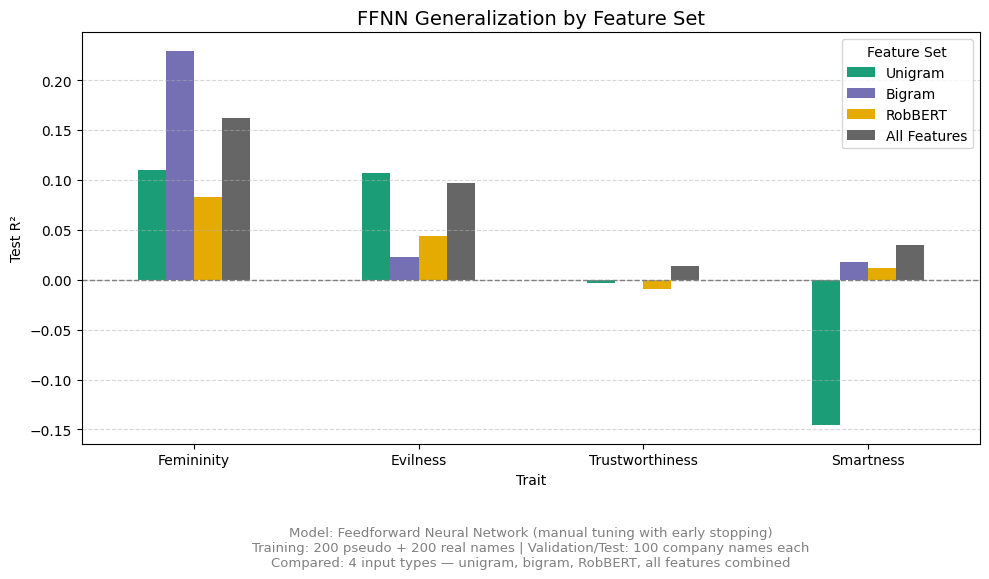

In [96]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── Paths ───────────────────────────────────────────────────────────────────────
BASE = r"C:\github\thesis\data\models"
METRICS_PATH = os.path.join(BASE, "model_ffnn_all_featuresets", "ffnn_all_feature_sets.csv")

# ── Load data ──────────────────────────────────────────────────────────────────
df = pd.read_csv(METRICS_PATH)

# ── Trait & feature naming ─────────────────────────────────────────────────────
trait_names = {
    "feminine": "Femininity",
    "evil": "Evilness",
    "trustworthy": "Trustworthiness",
    "smart": "Smartness"
}
df["trait"] = df["trait"].map(trait_names)

# Capitalize and rename feature sources
source_names = {
    "unigram": "Unigram",
    "bigram": "Bigram",
    "robbert": "RobBERT",
    "combined": "All Features"
}
df["source"] = df["features"].map(source_names)

# ── Ensure consistent trait order ──────────────────────────────────────────────
trait_order = ["Femininity", "Evilness", "Trustworthiness", "Smartness"]
source_order = list(source_names.values())

# ── Pivot for grouped bar chart ────────────────────────────────────────────────
pivot = df.pivot(index="trait", columns="source", values="test_r2").loc[trait_order, source_order]

# ── Plot setup ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind="bar", ax=ax, colormap="Dark2")

# ── Labels and explanation ─────────────────────────────────────────────────────
ax.set_ylabel("Test R²")
ax.set_xlabel("Trait")
ax.set_title("FFNN Generalization by Feature Set", fontsize=14)
ax.text(0.5, -0.2,
        "Model: Feedforward Neural Network (manual tuning with early stopping)\n"
        "Training: 200 pseudo + 200 real names | Validation/Test: 100 company names each\n"
        "Compared: 4 input types — unigram, bigram, RobBERT, all features combined",
        transform=ax.transAxes,
        ha='center', va='top', fontsize=9.5, color='gray')

ax.legend(title="Feature Set", loc="best")
ax.axhline(0, linestyle='--', color='gray', linewidth=1)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()

# ── Save plot ──────────────────────────────────────────────────────────────────
plot_path = os.path.join(BASE, "test_r2_ffnn_by_feature_set.png")
fig.savefig(plot_path)
print(f"✅ Annotated chart saved to:\n  {plot_path}")
plt.show()
